In [13]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from backtesting import Strategy
from backtesting import Backtest
from sklearn.model_selection import ParameterGrid
import multiprocessing as mp
import matplotlib.pyplot as plt
if mp.get_start_method(allow_none=True) != 'fork':
    mp.set_start_method('fork', force=True)
    
    
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap

In [14]:
def getYFinanceData(ticker, period, interval):
  dataF = yf.download(ticker, period=period, interval=interval, multi_level_index=False)

  # if dataF is None, return None
  if dataF is None or dataF.empty:
      raise ValueError(f"No data found for ticker {ticker} with period {period} and interval {interval}")
    
  dataF.iloc[:,:]
  #dataF.Open.iloc

  df = pd.DataFrame(dataF)

  # use df index, convert DateTime to  a column instead of index
  df.reset_index(inplace=True)

  # delete Adj Close
  # df = df.drop(['Adj Close'], axis=1)

  # rename Datetime to "Gmt time"
  df = df.rename(columns={'Datetime':'Gmt time'})
  
  # rename Date to "Gmt time"
  df = df.rename(columns={'Date':'Gmt time'})

  df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
  df.set_index("Gmt time", inplace=True)
  df=df[df.High!=df.Low]

  return df

In [15]:

testResults = dict()

In [ ]:
# Download data for a forex pair on a 5m timeframe as per the plan
# df = getYFinanceData("USDJPY=X", "60d", "15m")
df = getYFinanceData("EURUSD=X", "60d", "15m")
# df = getYFinanceData("EURJPY=X", "60d", "15m")
# df = getYFinanceData("AUDCAD=X", "60d", "15m")
# df = getYFinanceData("USDJPY=X", "60d", "15m")
# df = getYFinanceData("^SPX", "60d", "15m")
df.tail()

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_87952/2556758036.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataF = yf.download(ticker, period=period, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Gmt time,,,,,
2025-10-10 18:45:00+00:00,6594.490234,6607.009766,6590.790039,6601.770020,81663960
2025-10-10 19:00:00+00:00,6588.089844,6603.959961,6585.529785,6594.569824,87861758
2025-10-10 19:15:00+00:00,6581.770020,6594.370117,6578.049805,6588.069824,98137036
2025-10-10 19:30:00+00:00,6582.250000,6585.169922,6563.620117,6581.850098,151315895
2025-10-10 19:45:00+00:00,6552.799805,6589.770020,6550.779785,6582.399902,259883584


In [17]:
class QuantFVGStrategy(Strategy):
    # Optimization parameters
    tp_sl_ratio = 2.0
    fvg_min_size_atr_multiplier = 0.5
    fvg_candle_range_atr_multiplier = 1.5
    sl_atr_multiplier = 1.0  # Buffer for the stop loss
    fvg_expiry_bars = 10     # How many bars to wait for a retracement

    def init(self):
        # Indicators
        self.ema200 = self.I(lambda x: ta.ema(pd.Series(x), length=200), self.data.Close)
        self.atr = self.I(lambda high, low, close: ta.atr(high=pd.Series(high), low=pd.Series(low), close=pd.Series(close), length=14),
                          self.data.High, self.data.Low, self.data.Close)
        
        # State
        self.active_fvg = None

    def next(self):
        # If a position is open, we don't do anything.
        if self.position:
            return

        current_bar_index = len(self.data.Close) - 1
        current_atr = self.atr[-1]
        price = self.data.Close[-1]

        # --- FVG State Management & Entry ---
        if self.active_fvg:
            # 1. Check for FVG expiry
            if current_bar_index >= self.active_fvg['expiry']:
                self.active_fvg = None

            # 2. Check for FVG invalidation (price closes through the other side)
            if self.active_fvg and self.active_fvg['type'] == 'bearish' and price > self.active_fvg['top']:
                self.active_fvg = None
            
            if self.active_fvg and self.active_fvg['type'] == 'bullish' and price < self.active_fvg['bottom']:
                self.active_fvg = None

            # 3. Check for Confirmation & Entry, only if FVG is still active
            if self.active_fvg:
                if self.active_fvg['type'] == 'bearish':
                    # Confirmed if High has entered the FVG zone
                    if self.data.High[-1] > self.active_fvg['bottom']:
                        entry_price = self.data.Close[-1] # For TP calc, actual entry is next open
                        sl = self.active_fvg['sl']
                        tp = entry_price - self.tp_sl_ratio * (sl - entry_price)
                        self.sell(sl=sl, tp=tp)
                        self.active_fvg = None # Consume the FVG
                        return
                
                elif self.active_fvg['type'] == 'bullish':
                    # Confirmed if Low has entered the FVG zone
                    if self.data.Low[-1] < self.active_fvg['top']:
                        entry_price = self.data.Close[-1] # For TP calc
                        sl = self.active_fvg['sl']
                        tp = entry_price + self.tp_sl_ratio * (entry_price - sl)
                        self.buy(sl=sl, tp=tp)
                        self.active_fvg = None # Consume the FVG
                        return
                
                # If we have an active FVG but no entry signal, we wait.
                return

        # --- FVG Detection ---
        # Only look for a new FVG if there isn't an active one
        if not self.active_fvg:
            # Required data length for FVG detection
            if len(self.data.Close) < 20:
                return

            # Bearish FVG Signal
            if price < self.ema200[-1]:
                if self.data.Low[-3] > self.data.High[-1]:
                    fvg_top = self.data.Low[-3]
                    fvg_bottom = self.data.High[-1]
                    fvg_size = fvg_top - fvg_bottom
                    fvg_candle_range = self.data.High[-2] - self.data.Low[-2]

                    # Qualification filters
                    if (fvg_size > self.fvg_min_size_atr_multiplier * current_atr and
                        fvg_candle_range > self.fvg_candle_range_atr_multiplier * current_atr):
                        
                        # More robust SL placement
                        sl = self.data.High[-2] + self.sl_atr_multiplier * current_atr
                        
                        # Store the detected FVG to wait for confirmation
                        self.active_fvg = {
                            'type': 'bearish',
                            'top': fvg_top,
                            'bottom': fvg_bottom,
                            'sl': sl,
                            'expiry': current_bar_index + self.fvg_expiry_bars
                        }
                        return

            # Bullish FVG Signal
            if price > self.ema200[-1]:
                if self.data.High[-3] < self.data.Low[-1]:
                    fvg_bottom = self.data.High[-3]
                    fvg_top = self.data.Low[-1]
                    fvg_size = fvg_top - fvg_bottom
                    fvg_candle_range = self.data.High[-2] - self.data.Low[-2]

                    if (fvg_size > self.fvg_min_size_atr_multiplier * current_atr and
                        fvg_candle_range > self.fvg_candle_range_atr_multiplier * current_atr):

                        # More robust SL placement
                        sl = self.data.Low[-2] - self.sl_atr_multiplier * current_atr
                        
                        # Store the detected FVG
                        self.active_fvg = {
                            'type': 'bullish',
                            'top': fvg_top,
                            'bottom': fvg_bottom,
                            'sl': sl,
                            'expiry': current_bar_index + self.fvg_expiry_bars
                        }
                        return

Best stats:
Start                     2025-07-18 13:30...
End                       2025-10-10 19:45...
Duration                     84 days 06:15:00
Exposure Time [%]                   22.628205
Equity Final [$]                 114015.57123
Equity Peak [$]                 116871.571543
Return [%]                          14.015571
Buy & Hold Return [%]                3.882102
Return (Ann.) [%]                   73.480036
Volatility (Ann.) [%]              104.555895
Sharpe Ratio                         0.702782
Sortino Ratio                        1.927641
Calmar Ratio                         2.771961
Max. Drawdown [%]                  -26.508326
Avg. Drawdown [%]                   -3.086187
Max. Drawdown Duration       57 days 02:30:00
Avg. Drawdown Duration        4 days 17:14:00
# Trades                                   15
Win Rate [%]                        46.666667
Best Trade [%]                       1.224638
Worst Trade [%]                     -1.966054
Avg. Trade [%]        

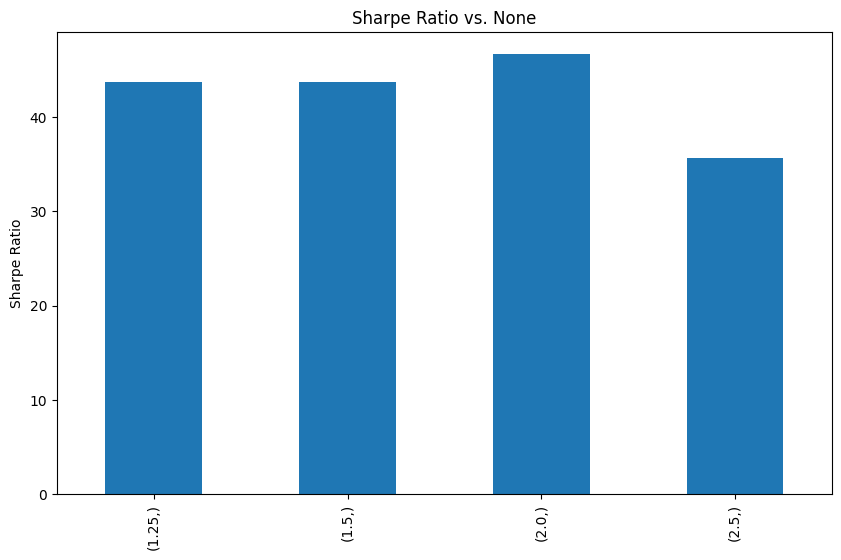

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_plotting.py:456: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(resample_rule, label='left')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_plotting.py:456: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(resample_rule, label='left')


In [ ]:
# --- Backtest ---
bt = Backtest(df, QuantFVGStrategy, cash=100000, margin=1/20)

# Optimize
stats, heatmap = bt.optimize(
    tp_sl_ratio=[1.25, 1.5, 2.0, 2.5],
    maximize='Win Rate [%]',
    return_heatmap=True,
)

print("Best stats:")
print(stats)

# Plot results
if heatmap is not None and not heatmap.isnull().all() and not heatmap.empty:
    if isinstance(heatmap.index, pd.MultiIndex) and heatmap.index.nlevels > 1:
        # For multi-parameter optimization, unstack and plot heatmap
        # Here we can only visualize 2 parameters at a time. We'll visualize the first two.
        param1 = heatmap.index.names[0]
        param2 = heatmap.index.names[1]
        heatmap_df = heatmap.unstack(level=param2).iloc[:,0] # Simplify for plotting
        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_df.unstack(), annot=True, cmap='viridis', fmt='.2f')
        plt.title(f'Sharpe Ratio Heatmap for {param1} and {param2}')
        plt.show()
    else:
        # For single parameter optimization, plot a bar chart
        plt.figure(figsize=(10, 6))
        heatmap.plot(kind='bar')
        plt.title(f'Sharpe Ratio vs. {heatmap.index.name}')
        plt.xlabel(heatmap.index.name)
        plt.ylabel('Sharpe Ratio')
        plt.show()
else:
    print("Optimization produced no results, likely because no trades were made. Skipping heatmap plot.")

# Plot equity curve and store results only if trades were made
if stats is not None and stats['# Trades'] > 0:
    bt.plot()
    strategyName = f"Quant_FVG_Strategy_Optimized"
    testResults[strategyName] = {
        "stats": stats,
        "heatmap": heatmap,
        "bt": bt,
    }
    bt.plot(filename=strategyName + ".html", resample=False)
else:
    print("No trades were made during the backtest. Skipping equity curve plot and result storage.")